In [188]:
from utils import show_task_activation, plot_fmap
from utils import process_gray_matter_mask, create_4d_volume, create_events_df, compute_task_fmap, compute_bins_threshold
from utils import subject_gm_mask_path, paradigm_dir, subject_task_active_mask_path, subject_task_regressor_path, subject_task_sample_prefix
from utils import mkdir_no_exist, x_coords, y_coords, z_coords
# from viz import plot_voxel_timecourse

import os
from os.path import join as pjoin
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from glob import glob

import nibabel as nib
from nilearn import image
from nilearn.glm import threshold_stats_img
from nilearn.glm.first_level import FirstLevelModel, run_glm
from nilearn.plotting import (
    plot_design_matrix,
    plot_stat_map,
    plot_img,
    plot_glass_brain,
)

In [12]:
HCP_dir = '/media/miplab-nas2/HCP-Data'
paradigm_dir = pjoin(HCP_dir,'HCP_100unrelated_TaskParadigms')
fMRI_dir = pjoin(HCP_dir,'HCP_100unrelated_preprocessed_ERG/data')

project_dir = '/media/RCPNAS/Data2/CS-433-ML4S/'
project_data_dir = pjoin(project_dir, 'data')
project_dataset_dir = pjoin(project_dir, "dataset")

derivatives_dir = pjoin(project_data_dir, 'derivatives')

anat_dir = pjoin(derivatives_dir, 'anat')
func_dir = pjoin(derivatives_dir, 'func')
events_dir = pjoin(project_data_dir, 'events')

mkdir_no_exist(anat_dir)
mkdir_no_exist(func_dir)
mkdir_no_exist(events_dir)
mkdir_no_exist(project_dataset_dir)

In [13]:
subject = "127630"
task = "MOTOR"
acq = "RL"
smoothing = 10
TR = 0.72 

In [3]:
def subject_run(sid, acquisition):
    return {"id": sid, "acquisition": acquisition}

In [209]:
def plot_voxel_timecourse(predicted_voxel, regressors):
    plt.figure(figsize=(20, 5))

    n_voxels = predicted_voxel.shape[0]
    max_h = 0.0
    for i in range(n_voxels):
        max_h = max(max_h, np.max(predicted_voxel[i,:]))
        plt.plot(predicted_voxel[i,:], alpha=0.3)
    
    
    df = regressors_to_binary_design(regressors)
    for col in df.columns:
        plt.fill_between(range(len(df)), df[col] * max_h, label=col, alpha=0.3)

    plt.title('Individual Voxel Timecourses')
    plt.xticks(np.linspace(0, predicted_voxel.shape[1], num=10))
    plt.xlabel('Time')
    plt.ylabel('Signal')
    plt.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=len(df.columns)//2)
    plt.show()

In [200]:
def voxel_activation_glm(mask_img, TR, fmri_vols, events):
    fmri_glm = FirstLevelModel(
        mask_img=mask_img,
        t_r=TR,
        noise_model='ar1', # or ols 
        standardize=False,
        hrf_model='spm',
        drift_model=None, # not necessary, nuisance covariates have already been removed
        minimize_memory=False,
    )

    print(f"fitting GLM for task {task}")
    fitted_glm = fmri_glm.fit(fmri_vols, events)
    return fitted_glm

In [5]:
def raw_voxel_activity_glm(mask_img, TR, fmri_vols, events):
    fmri_glm = FirstLevelModel(
        mask_img=mask_img,
        t_r=TR,
        noise_model='ar1', # or ols 
        standardize=False,
        hrf_model=None,
        drift_model=None, # not necessary, nuisance covariates have already been removed
        minimize_memory=False,
    )

    print(f"fitting GLM for task {task}")
    fitted_glm = fmri_glm.fit(fmri_vols, events)
    return fitted_glm

In [6]:
def create_active_voxel_mask(subject, task, acquisition, smoothing, voxel_quantile, base_gm_mask_img, fmap_img, threshold):
    task_active_thr_map = subject_task_active_mask_path(subject, task, acquisition, smoothing, voxel_quantile)
    if os.path.isfile(task_active_thr_map):
        return nib.load(task_active_thr_map)

    gm_mask_data = base_gm_mask_img.get_fdata()
    fmap_data = fmap_img.get_fdata()

    threshold_mask = (fmap_data > threshold)

    active_data = fmap_data
    active_data[~threshold_mask] = 0
    active_data[threshold_mask] = 1

    active_img = nib.Nifti1Image(active_data, affine=base_gm_mask_img.affine, header=base_gm_mask_img.header)
    active_img.to_filename(task_active_thr_map)

    return active_img

In [7]:
def create_labeled_sample(save_prefix, bold_data, predicted_data, active_mask):
    voxel_coords = np.array(np.where((active_mask > 0))).T
    np.save(f'{save_prefix}voxel_mapping.npy', voxel_coords)

    X_list, Y_list = bold_data[active_mask > 0], predicted_data[active_mask > 0]
    for i, (X, Y) in enumerate(zip(X_list, Y_list)):
        np.save(f'{save_prefix}X_{i:04d}.npy', X)
        np.save(f'{save_prefix}Y_{i:04d}.npy', Y)

In [8]:
def prepare_subject_sample(subject, task, acquisition, smoothing, voxel_quantile=98):
    gm_mask = subject_gm_mask_path(subject)
    print("processing subject gray matter mask", gm_mask)
    process_gray_matter_mask(anat_dir, subject, border_size=2, save=True, plot=False)

    print(f"concatenating volumes for task {task}")
    fmri_vols = create_4d_volume(subject, task, acquisition, smoothing, save=True)

    print("processing event conditions")
    independent_events = create_events_df(subject, task, acquisition)
    regressors = scipy.io.loadmat(subject_task_regressor_path(subject, task, acquisition))
    flat_regressors = regressors['Regressor'].flatten()

    print("first GLM to select active voxel")
    activity_glm = voxel_activation_glm(gm_mask, TR, fmri_vols, independent_events)

    print(f"computing f-map and selecting {voxel_quantile}th voxel")
    n_regressors = activity_glm.design_matrices_[0].shape[1]
    contrast_matrix = np.zeros((n_regressors-1, n_regressors))
    np.fill_diagonal(contrast_matrix, 1)
    
    fmap = compute_task_fmap(subject, task, acquisition, smoothing, activity_glm, contrast_matrix)
    threshold = compute_bins_threshold(fmap, n_perc=voxel_quantile)

    plot_fmap(fmap, threshold, display_mode="x", task=task, info={"subj": subject}, cut_cords=x_coords)
    plot_fmap(fmap, threshold, display_mode="y", task=task, info={"subj": subject}, cut_cords=y_coords)
    plot_fmap(fmap, threshold, display_mode="z", task=task, info={"subj": subject}, cut_cords=z_coords)

    gm_mask = nib.load(gm_mask)
    active_mask = create_active_voxel_mask(subject, task, acquisition, smoothing, voxel_activation_glm, gm_mask, fmap, threshold)
    active_mask_data = active_mask.get_fdata()
    
    #plot_img(gm_mask)
    #plot_img(active_mask)

    print("second GLM to extract raw voxel activity")
    raw_voxel_glm = raw_voxel_activity_glm(active_mask, TR, fmri_vols, independent_events)
    predicted = raw_voxel_glm.predicted[0]
    predicted_data = predicted.get_fdata()

    plot_voxel_timecourse(predicted_data[active_mask_data > 0], flat_regressors)

    print("generating labeled sample from fmri run")
    sample_prefix = subject_task_sample_prefix(subject, task, acquisition, smoothing, voxel_quantile)
    create_labeled_sample(sample_prefix, fmri_vols.get_fdata(), predicted_data, active_mask_data)

    print("done")

In [9]:
subjetcs = [subject_run("127630", "RL")]

processing subject gray matter mask /media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/127630_gm_mask.nii.gz
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/127630_gm_mask.nii.gz


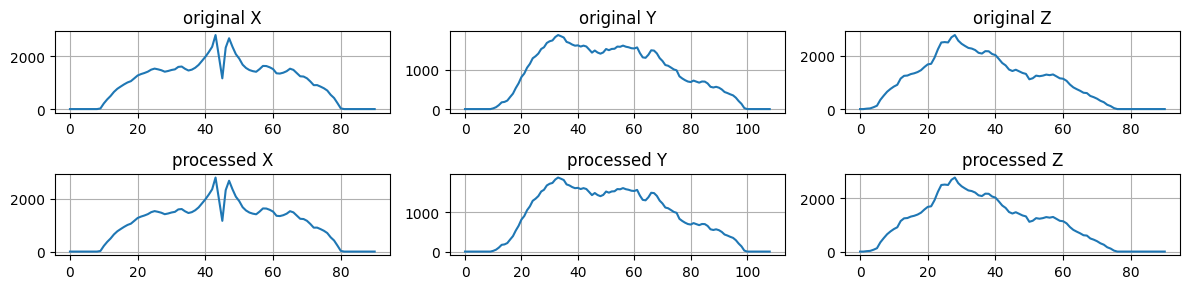

concatenating volumes for task MOTOR
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/127630_MOTOR_RL_smooth-10mm_fMRIvols.nii.gz
files 127630_MOTOR_RL_smooth-10mm_fMRIvols.nii.gz already exists, skipping processing
processing event conditions
/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/127630_Regressor_tfMRI_MOTOR_RL.mat
/media/RCPNAS/Data2/CS-433-ML4S/data/events/127630_MOTOR_RL_event.csv
first GLM to select active voxel
fitting GLM for task MOTOR
computing f-map and selecting 98th voxel


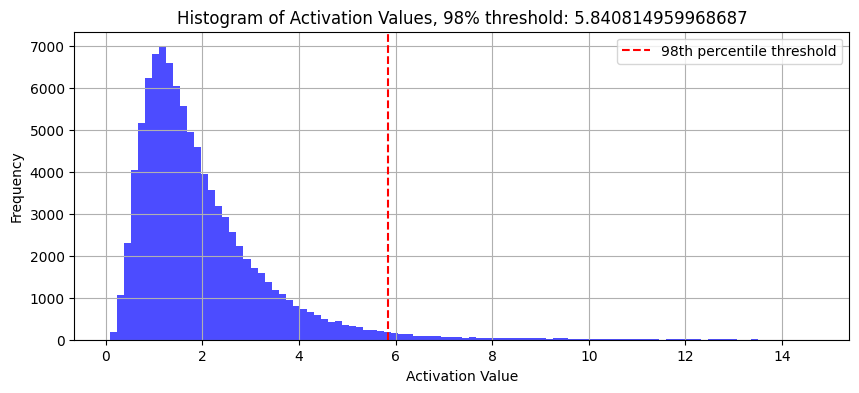

second GLM to extract raw voxel activity
fitting GLM for task MOTOR
discarded 0 / 1937


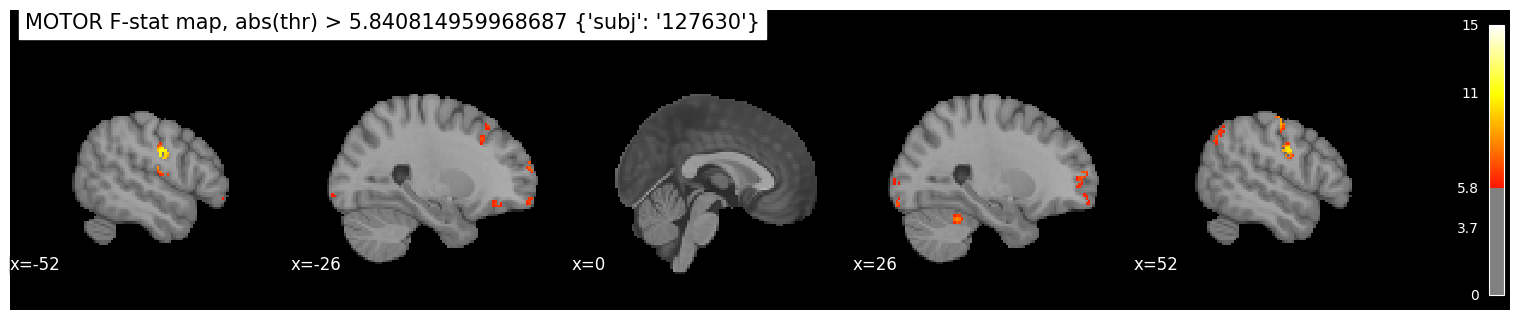

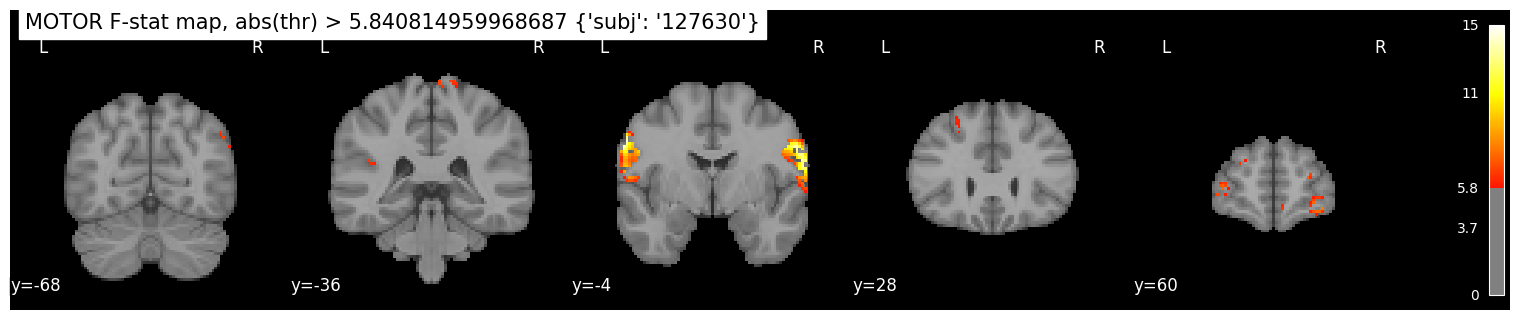

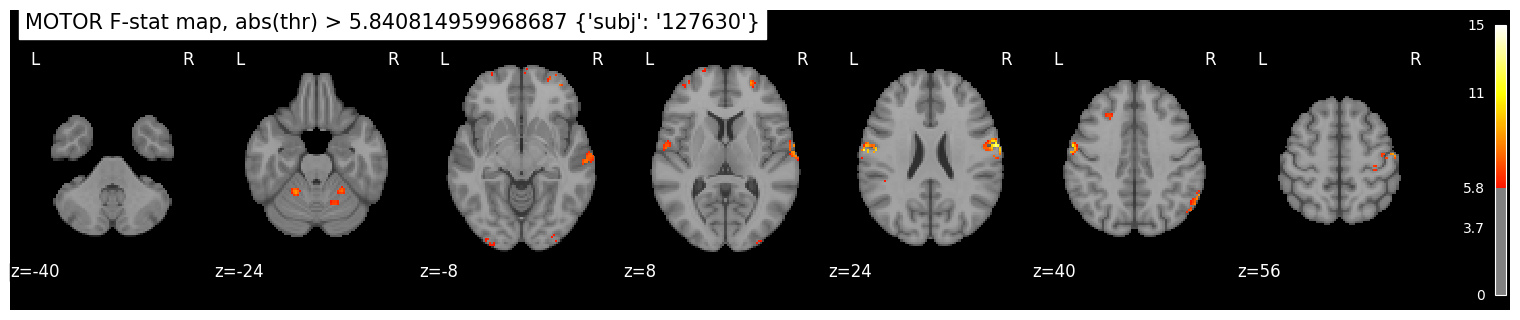

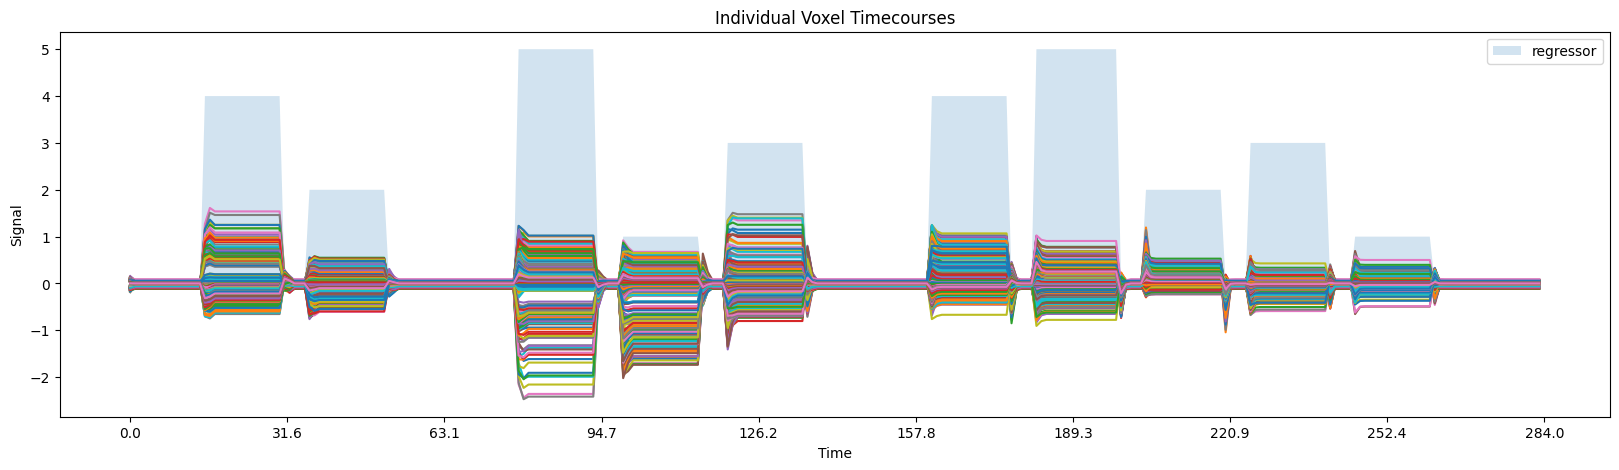

generating labeled sample from fmri run
done


In [23]:
for entry in subjetcs:
    prepare_subject_sample(entry.get("id"), task, entry.get("acquisition"), smoothing=10)

processing subject gray matter mask /media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/113619_gm_mask.nii.gz
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/113619_gm_mask.nii.gz


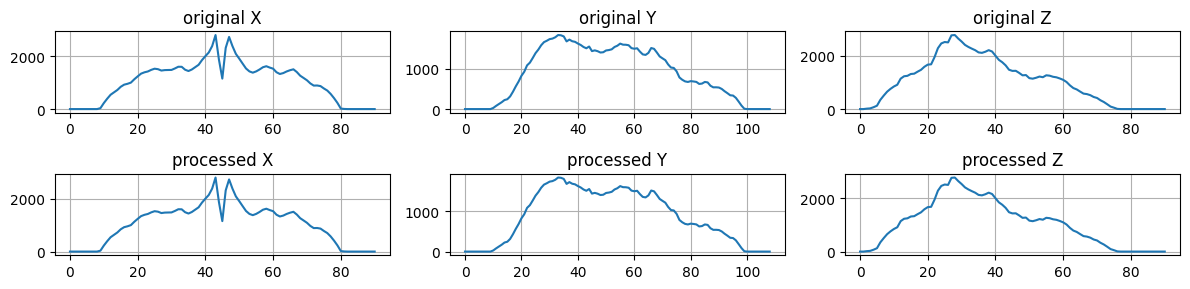

concatenating volumes for task MOTOR
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/113619_MOTOR_LR_smooth-10mm_fMRIvols.nii.gz
files 113619_MOTOR_LR_smooth-10mm_fMRIvols.nii.gz already exists, skipping processing
processing event conditions
/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/113619_Regressor_tfMRI_MOTOR_LR.mat
/media/RCPNAS/Data2/CS-433-ML4S/data/events/113619_MOTOR_LR_event.csv
first GLM to select active voxel
fitting GLM for task MOTOR
computing f-map and selecting 98th voxel


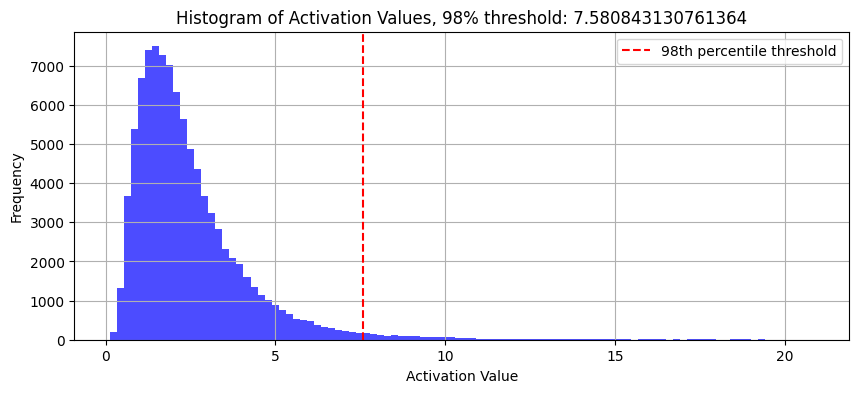

second GLM to extract raw voxel activity
fitting GLM for task MOTOR
discarded 0 / 1930


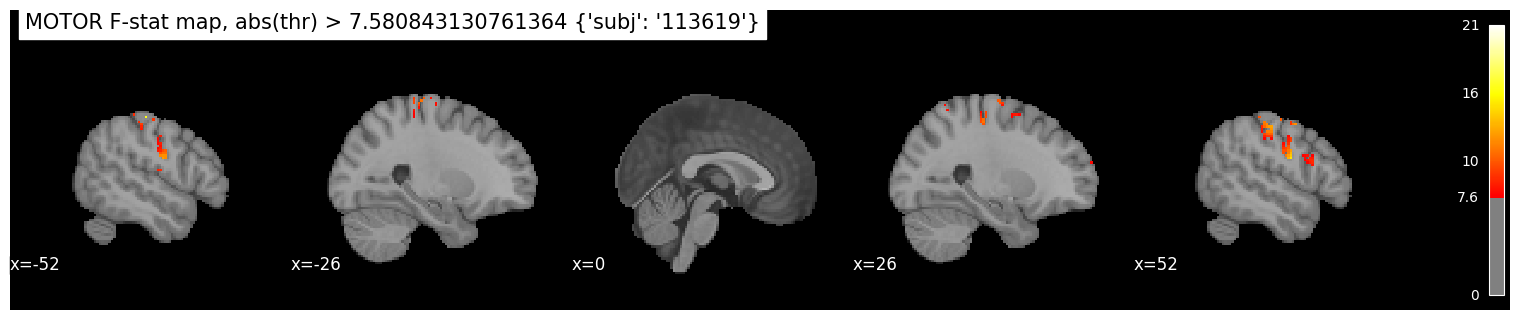

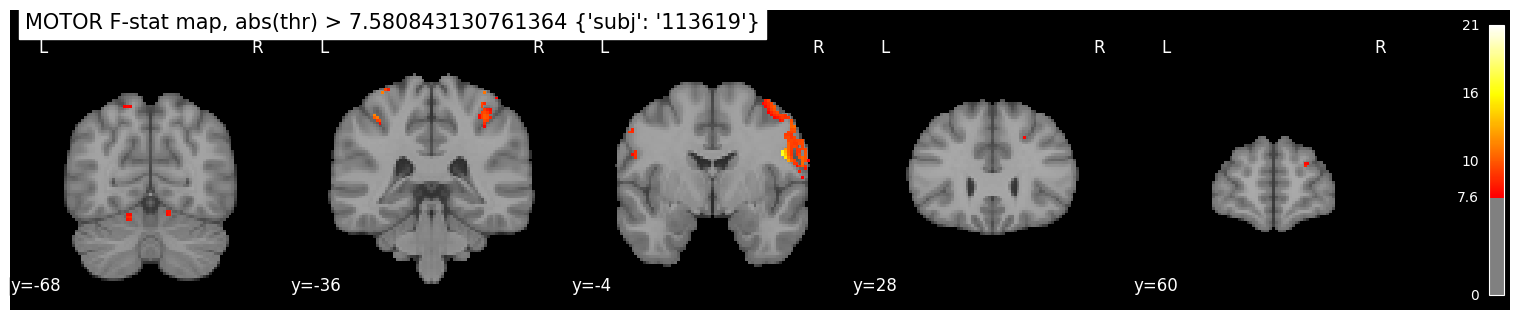

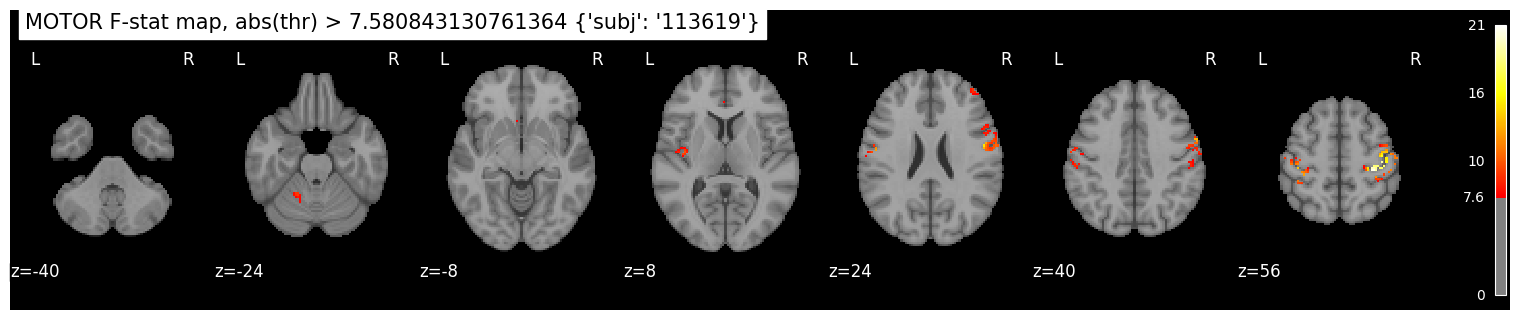

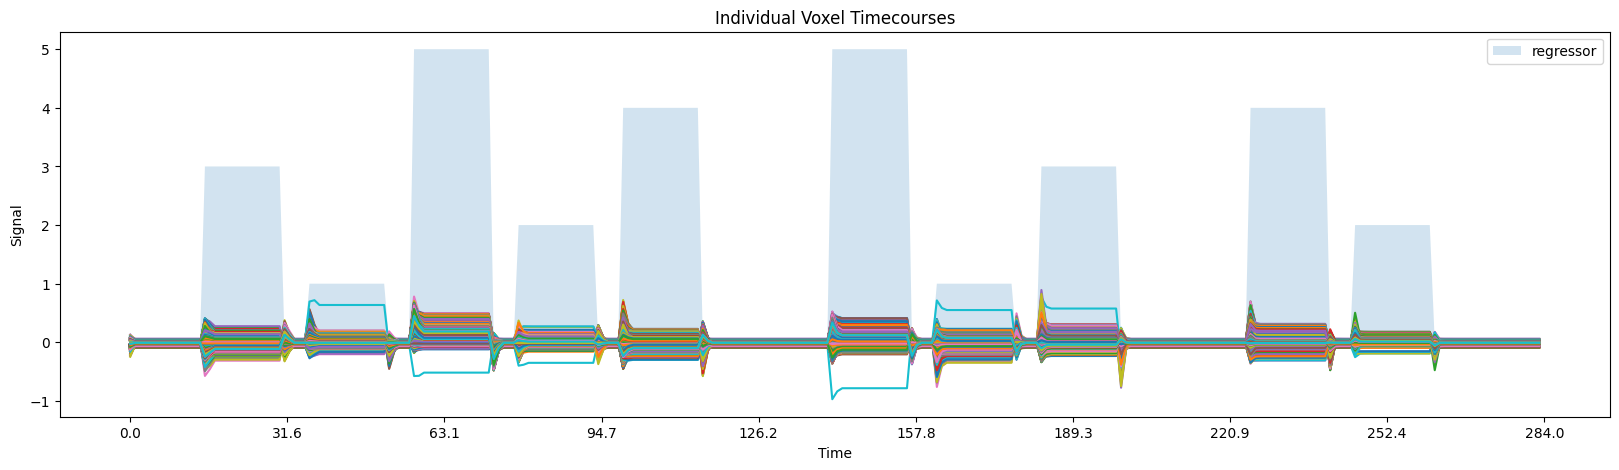

generating labeled sample from fmri run
done


In [24]:
prepare_subject_sample("113619", task, "LR", smoothing=10)

In [60]:
sample_prefix = subject_task_sample_prefix("113619", "MOTOR", "LR", 10, 98)
print(sample_prefix)

def load_and_reconstruct_volume(prefix, vol_shape=(91, 109, 91)):
    X_files = sorted(glob(f"{prefix}X_*.npy"))
    Y_files = sorted(glob(f"{prefix}Y_*.npy"))
    
    # Load first file to get timepoints dimension
    first_X = np.load(X_files[0])
    n_timepoints = first_X.shape[0]
    
    flat_X = np.vstack([np.load(f) for f in X_files])
    flat_Y = np.vstack([np.load(f) for f in Y_files])
    
    mask = np.zeros(vol_shape)
    voxel_coords = np.where(mask.flatten() != 0)
    
    X_vol = np.zeros((*vol_shape, n_timepoints))
    Y_vol = np.zeros((*vol_shape, n_timepoints))
    
    X_vol.reshape(-1, n_timepoints)[voxel_coords] = flat_X
    Y_vol.reshape(-1, n_timepoints)[voxel_coords] = flat_Y
    
    return X_vol, Y_vol

/media/RCPNAS/Data2/CS-433-ML4S/dataset/113619_MOTOR_LR_smooth-10mm_98_


In [61]:
X_vol, Y_vol = load_and_reconstruct_volume(sample_prefix)

ValueError: shape mismatch: value array of shape (1930,284) could not be broadcast to indexing result of shape (0,284)

In [31]:
X_loaded

[]

In [50]:
x = np.load('/media/RCPNAS/Data2/CS-433-ML4S/dataset/113619_MOTOR_LR_smooth-10mm_98_X_0949.npy')

In [52]:
x.shape

(284,)

processing subject gray matter mask /media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/127630_gm_mask.nii.gz
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/127630_gm_mask.nii.gz


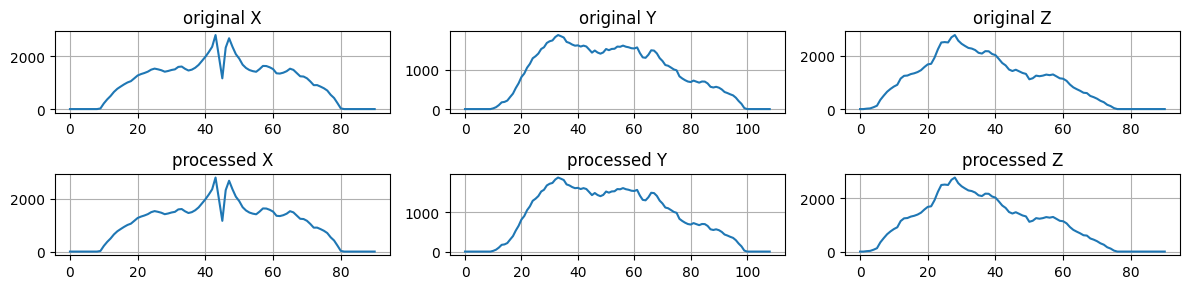

concatenating volumes for task MOTOR
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/127630_MOTOR_RL_smooth-10mm_fMRIvols.nii.gz
files 127630_MOTOR_RL_smooth-10mm_fMRIvols.nii.gz already exists, skipping processing
processing event conditions
/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/127630_Regressor_tfMRI_MOTOR_RL.mat
/media/RCPNAS/Data2/CS-433-ML4S/data/events/127630_MOTOR_RL_event.csv
first GLM to select active voxel
fitting GLM for task MOTOR
computing f-map and selecting 98th voxel


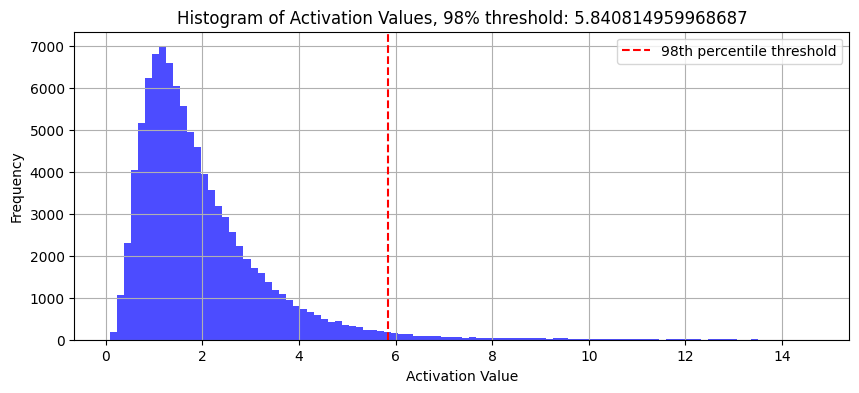

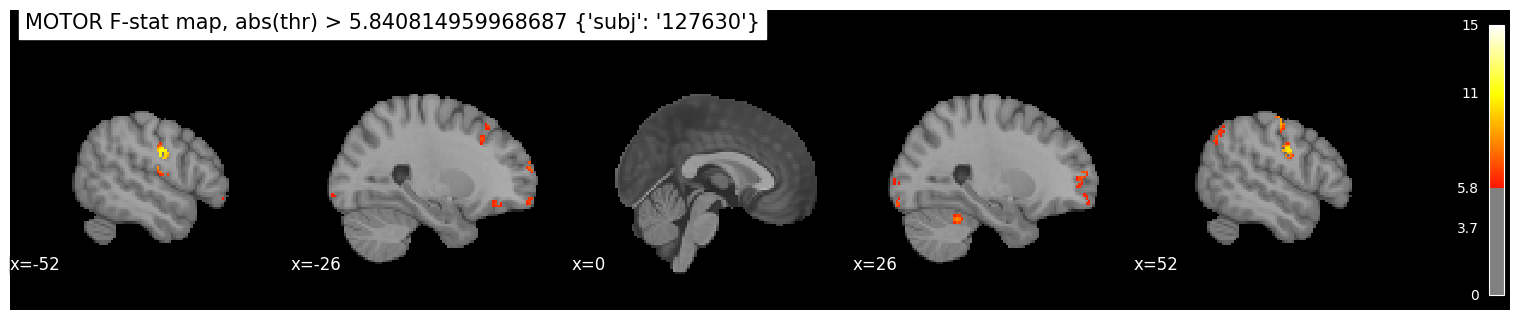

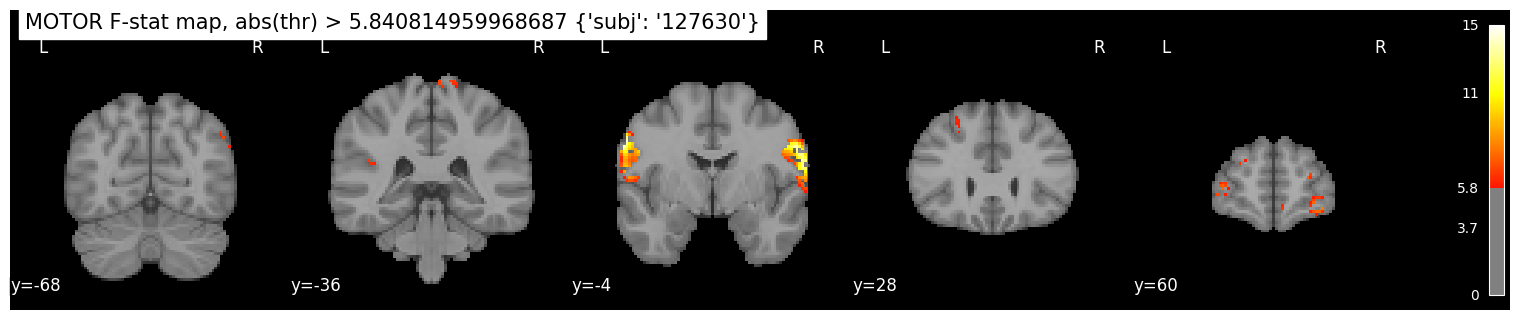

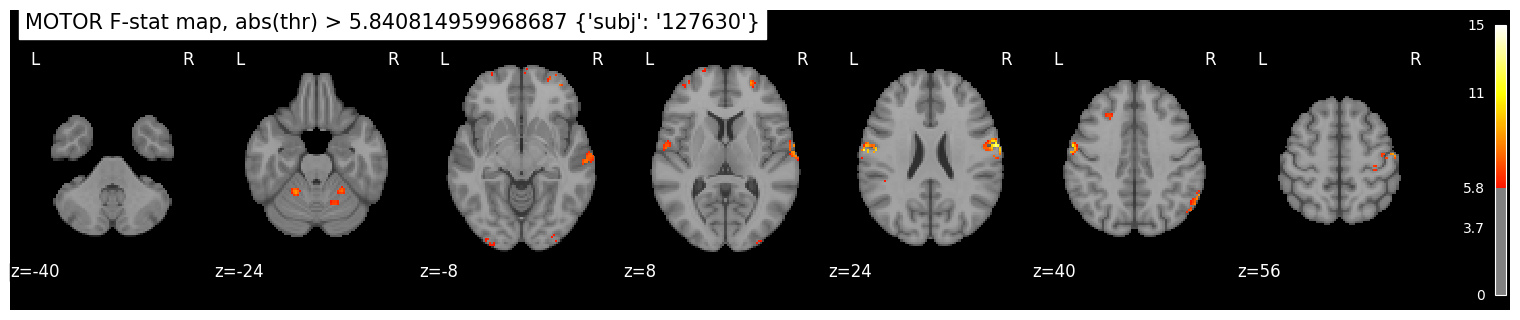

second GLM to extract raw voxel activity
generating labeled sample from fmri run
done


In [14]:
acquisition = acq
voxel_quantile = 98

gm_mask = subject_gm_mask_path(subject)
print("processing subject gray matter mask", gm_mask)
process_gray_matter_mask(anat_dir, subject, border_size=2, save=True, plot=False)

print(f"concatenating volumes for task {task}")
fmri_vols = create_4d_volume(subject, task, acquisition, smoothing, save=True)

print("processing event conditions")
independent_events = create_events_df(subject, task, acquisition)
regressors = scipy.io.loadmat(subject_task_regressor_path(subject, task, acquisition))
flat_regressors = regressors['Regressor'].flatten()

print("first GLM to select active voxel")
activity_glm = voxel_activation_glm(gm_mask, TR, fmri_vols, independent_events)

print(f"computing f-map and selecting {voxel_quantile}th voxel")
n_regressors = activity_glm.design_matrices_[0].shape[1]
contrast_matrix = np.zeros((n_regressors-1, n_regressors))
np.fill_diagonal(contrast_matrix, 1)

fmap = compute_task_fmap(subject, task, acquisition, smoothing, activity_glm, contrast_matrix)
threshold = compute_bins_threshold(fmap, n_perc=voxel_quantile)

plot_fmap(fmap, threshold, display_mode="x", task=task, info={"subj": subject}, cut_cords=x_coords)
plot_fmap(fmap, threshold, display_mode="y", task=task, info={"subj": subject}, cut_cords=y_coords)
plot_fmap(fmap, threshold, display_mode="z", task=task, info={"subj": subject}, cut_cords=z_coords)

gm_mask = nib.load(gm_mask)
active_mask = create_active_voxel_mask(subject, task, acquisition, smoothing, voxel_activation_glm, gm_mask, fmap, threshold)
active_mask_data = active_mask.get_fdata()

#plot_img(gm_mask)
#plot_img(active_mask)

print("second GLM to extract raw voxel activity")
# raw_voxel_glm = raw_voxel_activity_glm(active_mask, TR, fmri_vols, independent_events)
# predicted = raw_voxel_glm.predicted[0]
# predicted_data = predicted.get_fdata()

# plot_voxel_timecourse(predicted_data[active_mask_data > 0], flat_regressors)

print("generating labeled sample from fmri run")
# sample_prefix = subject_task_sample_prefix(subject, task, acquisition, smoothing, voxel_quantile)
# create_labeled_sample(sample_prefix, fmri_vols.get_fdata(), predicted_data, active_mask_data)

print("done")

In [ ]:
def get_beta(glm):

In [211]:
def regressors_to_binary_design(regressors):
    changes = np.where(np.diff(flat_regressors) != 0)[0] + 1
    blocks = np.zeros((len(flat_regressors), len(changes[flat_regressors[changes] != 0])))
    
    cols = []
    block_idx = 0
    for i, j in zip(changes, changes[1:]):
        if flat_regressors[i] != 0:
            blocks[i:j, block_idx] = 1
            cols.append(f"block_{block_idx}_cond_{flat_regressors[i]}")
            block_idx += 1
    
    return pd.DataFrame(blocks, columns=cols)

In [214]:
regressors_to_binary_design(flat_regressors);

In [110]:
def get_predicted_bold_response(glm, active_mask_data, regressors):    
    predicted = glm.predicted[0]
    predicted_data = predicted.get_fdata()[active_mask_data > 0]

    plot_voxel_timecourse(predicted_data, regressors)
    print(predicted_data.shape)

    return predicted_data

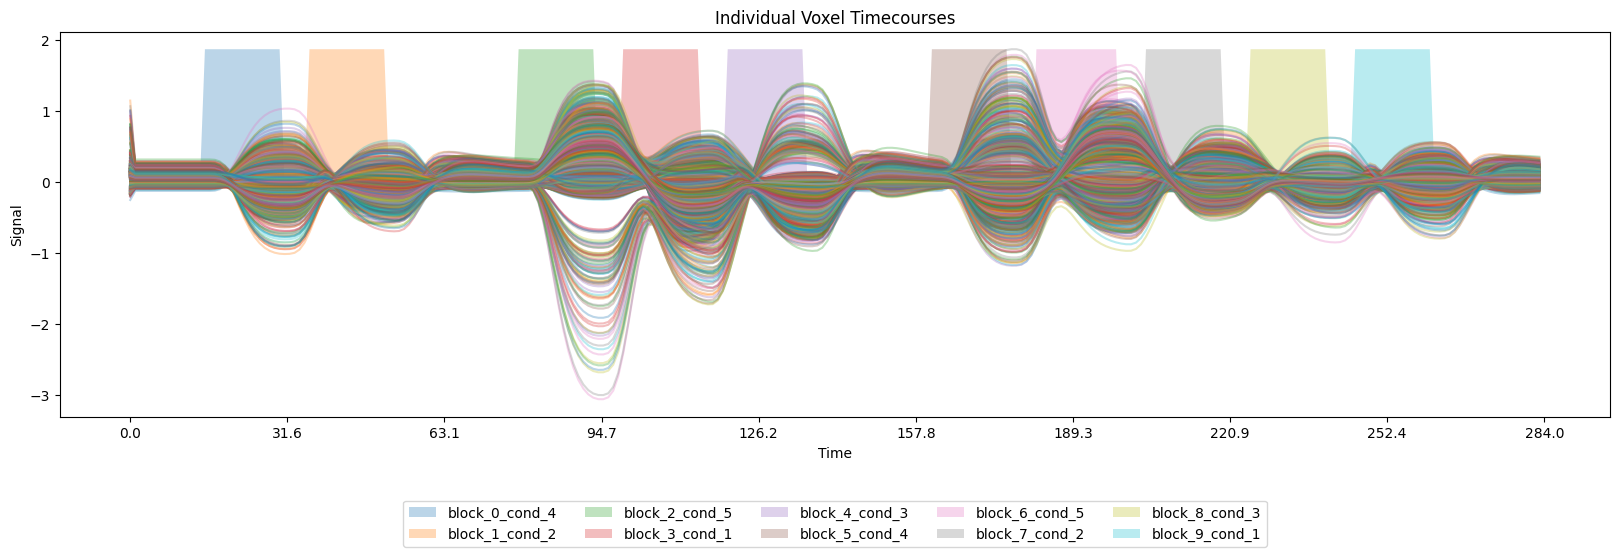

(1937, 284)


In [213]:
get_predicted_bold_response(activity_glm, active_mask_data, flat_regressors);

HRF convoluted, sweet

In [267]:
def get_predicted_neural_activity(glm, active_mask_data, regressors):
    n_conditions = np.count_nonzero(contrast_matrix)
    # actual response (amplitude) in the voxel for each of the n_conditions
    betas = glm.compute_contrast(contrast_matrix, output_type='effect_size')
    betas_data = betas.get_fdata()
    active_voxel_beta = betas_data[active_mask_data > 0].reshape(-1, n_conditions)

    binary_design = regressors_to_binary_design(flat_regressors).to_numpy()

    predicted_neural_activity =  active_voxel_beta @ binary_design.T

    print(predicted_neural_activity.shape)
    plot_voxel_timecourse(predicted_neural_activity, regressors)
    
    return predicted_timecourse

(1937, 284)


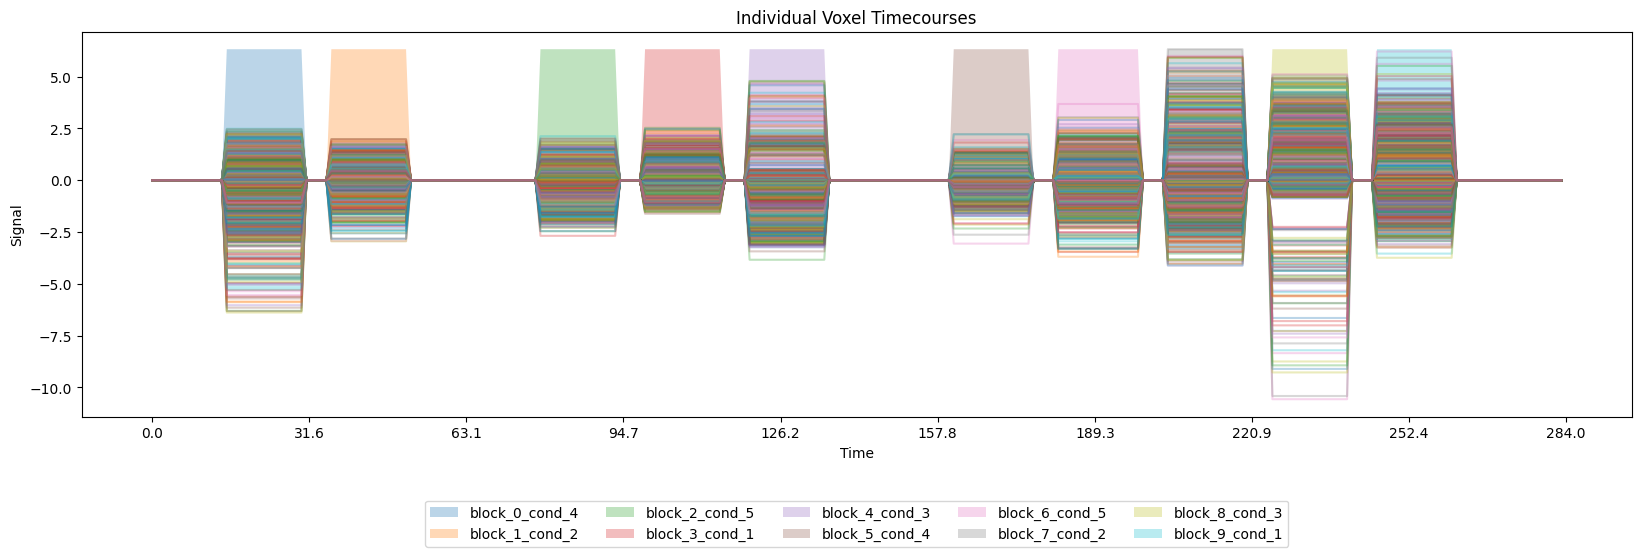

In [268]:
get_predicted_neural_activity(activity_glm, active_mask_data, flat_regressors);

In [260]:
def get_condition_amplitudes(glm, active_mask_data, regressors):
    return 1

In [261]:
betas = activity_glm.compute_contrast(contrast_matrix, output_type='effect_size')

In [262]:
betas_data = betas.get_fdata()
active_voxel_beta = betas_data[active_mask_data > 0].reshape(-1, n_conditions)

In [263]:
active_voxel_beta.shape

(1937, 10)

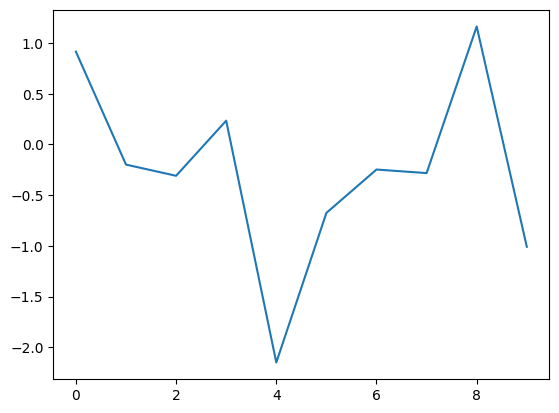

In [302]:
plt.plot(active_voxel_beta[0])

In [271]:
binary_design = regressors_to_binary_design(flat_regressors).to_numpy()
binary_design.shape

(284, 10)

In [312]:
def get_predicted_neural_activity_per_condition(binary_design, betas):
    # binary_design: (T × C) = (284 × 10)
    # betas: (V × C) = (1937 × 10)
    # out output: (C × T × V) = (10 × 284 × 1937) beta for each condition for each ts for each voxel_activiy
    print("binary_design", binary_design.shape, "betas", betas.shape)
    
    predictions = np.zeros((
        binary_design.shape[1],  # C = 10
        binary_design.shape[0],  # T = 284
        betas.shape[0],          # V = 1937
    ))

    print("pred", predictions.shape)
                          
    for c in range(binary_design.shape[1]):
        # binary_design[:, c] is (T,)
        # betas[:, c] is (V,)
        # outer product to get (T × V) for this condition
        # basically I want to be able to separate betas across condition (skip '@' = Sum_i beta_i cond_i)
        print(binary_design[:, c].shape, betas[:, c].shape)
        predictions[c] = np.outer(binary_design[:, c], betas[:, c])
    
    return predictions

neural_activity_cond = get_predicted_neural_activity_per_condition(
    binary_design, 
    active_voxel_beta
)
print(neural_activity_cond.shape)

binary_design (284, 10) betas (1937, 10)
pred (10, 284, 1937)
(284,) (1937,)
(284,) (1937,)
(284,) (1937,)
(284,) (1937,)
(284,) (1937,)
(284,) (1937,)
(284,) (1937,)
(284,) (1937,)
(284,) (1937,)
(284,) (1937,)
(10, 284, 1937)


In [305]:
neural_activity_cond.shape

(10, 284, 1937)

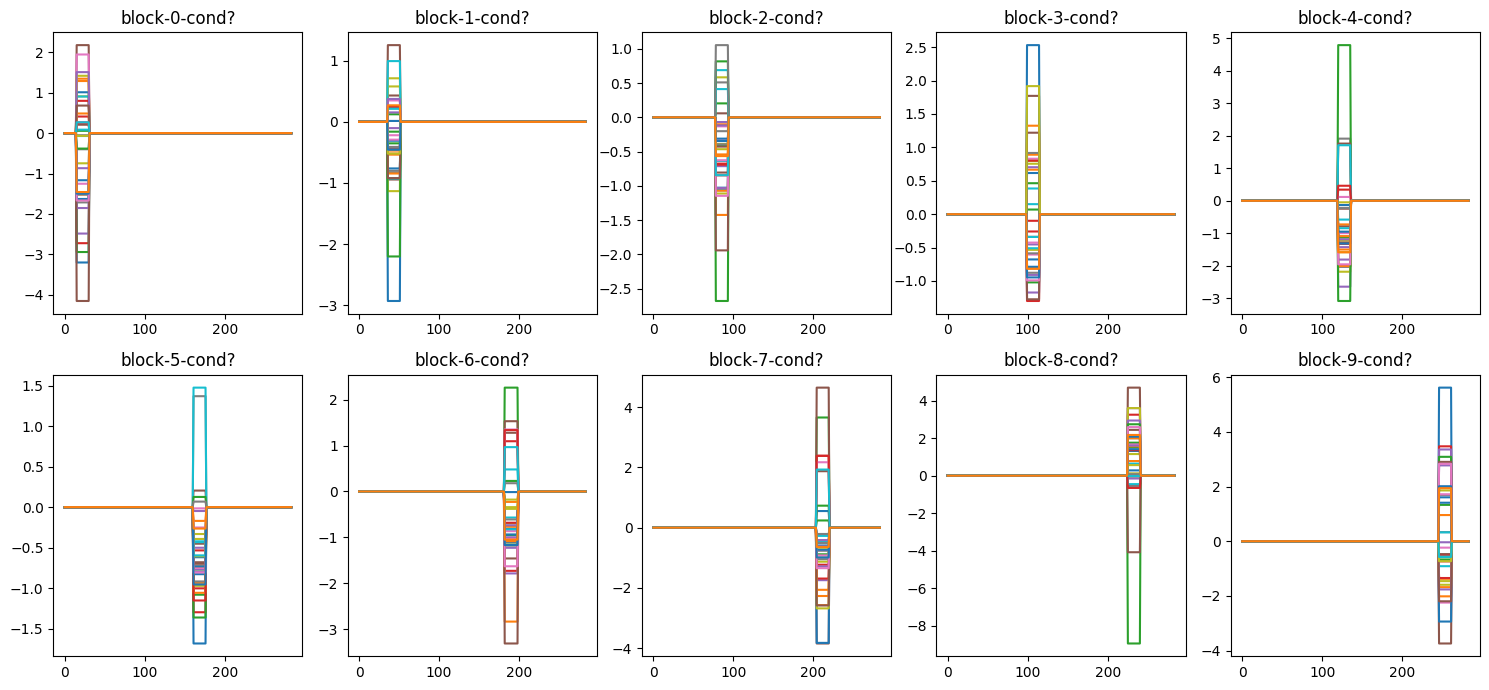

In [328]:
pick = 42
rand_voxel = np.random.choice(np.arange(0, neural_activity_cond.shape[2]), pick, replace=False)

plt.figure(figsize=(15, 7))
for c in range(neural_activity_cond.shape[0]):
    plt.subplot(2, 5, c+1)
    plt.plot(neural_activity_cond[c, :, rand_voxel].T) 
    plt.title(f'block-{c}-cond?')
plt.tight_layout()

so this one is cool, but completely uselss as it's specific to each condition. ok to predict condition given raw signal, useless for more general stuff

In [19]:
def plot_beta_voxel_timecourse(predicted_voxel):
    n_voxels = predicted_voxel.shape[0]
    plt.figure(figsize=(20, 5))

    discared = 0
    for i in range(n_voxels):
        if np.any(np.abs(predicted_voxel[i,:]) > 20):
            discared += 1
            continue
        plt.plot(predicted_voxel[i,:])
    
    print(f"discarded {discared} / {n_voxels}")
    plt.title('Individual Voxel Timecourses')
    plt.xticks(np.linspace(0, predicted_voxel.shape[1], num=10))
    plt.xlabel('Time')
    plt.ylabel('Signal')
    plt.legend()
    plt.show()

In [21]:
active_betas = beta_data[active_mask_data > 0]

In [22]:
active_betas.shape

(1937, 10)

In [32]:
active_betas_per_voxel = np.sum(active_betas, axis=1)
active_betas.shape

(1937, 10)

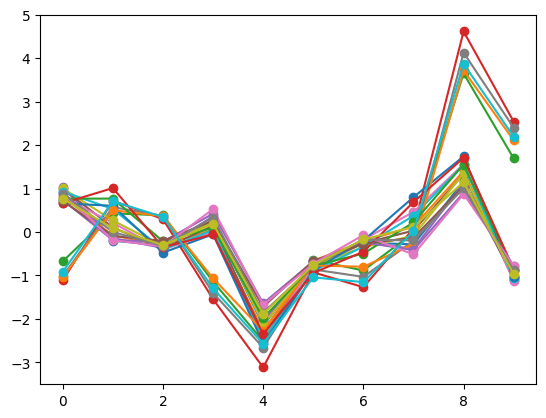

In [44]:
plt.plot(active_betas[:20, :].T, '-o');

discarded 0 / 1937


/tmp/ipykernel_2011929/537391200.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


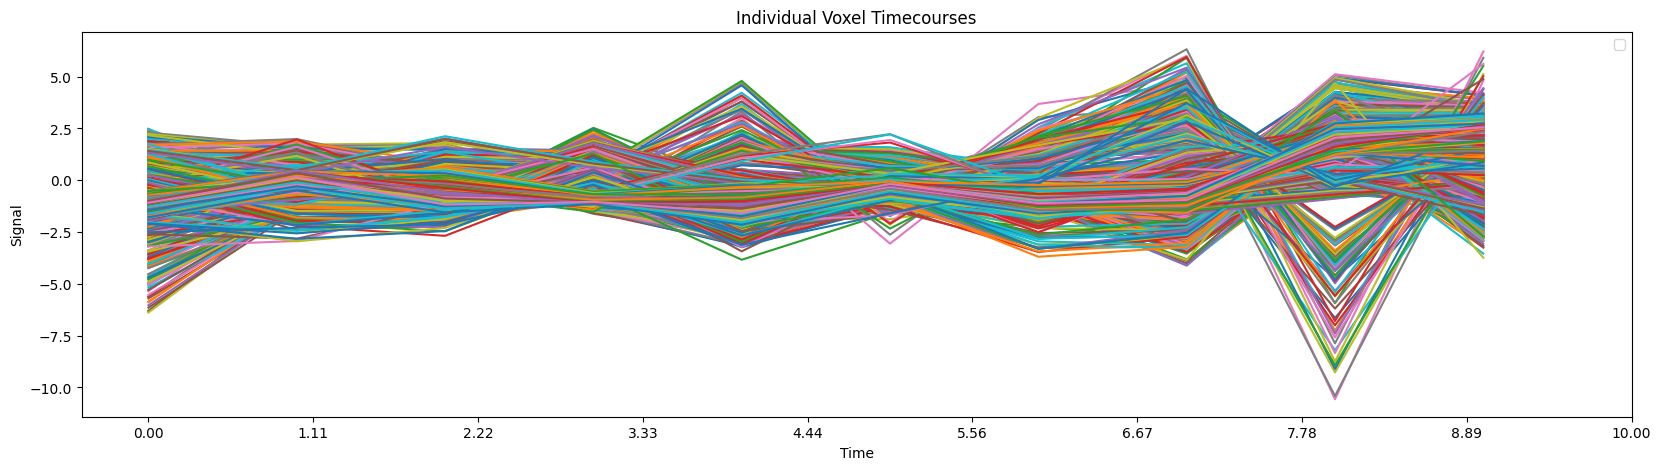

In [25]:
plot_beta_voxel_timecourse(beta_data[active_mask_data > 0])

In [53]:
beta_data[active_mask_data > 0].shape

(1937, 10)

In [82]:
design_matrix = activity_glm.design_matrices_[0]

n_timepoints = fmri_vols.shape[3]
condition_names = independent_events['trial_type'].unique()
condition_to_idx = {name: idx for idx, name in enumerate(condition_names)}
n_conditions = len(condition_names)
binary_design = np.zeros((n_timepoints, n_conditions))

for event in independent_events.itertuples():
    start_idx = int(event.onset / TR)
    duration_idx = int(event.duration / TR)
    condition_idx = condition_to_idx[event.trial_type]
    binary_design[start_idx:start_idx+duration_idx, condition_idx] = 1

beta_maps = activity_glm.compute_contrast(contrast_matrix, output_type='effect_size')
beta_data = beta_maps.get_fdata()

beta_data_reshaped = beta_data.reshape(-1, n_conditions)
active_voxel_mask = active_mask_data.reshape(-1) > 0
active_betas = beta_data_reshaped[active_voxel_mask, :]

predicted_timecourse =  active_betas @ binary_design.T

print("Shape of binary_design:", binary_design.shape)
print("Shape of active_betas:", active_betas.shape)
print("Shape of predicted_timecourse:", predicted_timecourse.shape)

Shape of binary_design: (284, 10)
Shape of active_betas: (1937, 10)
Shape of predicted_timecourse: (1937, 284)


In [53]:
beta_data_reshaped.shape

(902629, 10)

In [83]:
binary_design.shape

(284, 10)

In [88]:
binary_design[:50, :]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 

In [55]:
active_betas.shape

(1937, 10)

In [39]:
predicted_timecourse.shape

(284, 1937)

discarded 0 / 1937


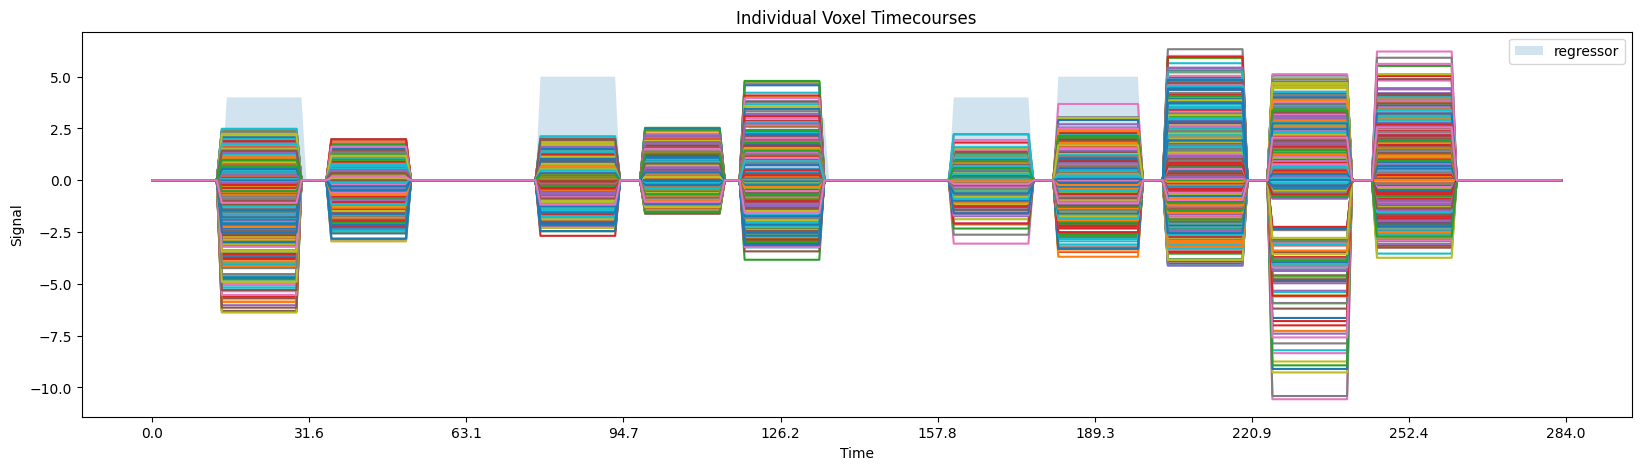

In [65]:
plot_voxel_timecourse(predicted_timecourse, flat_regressors)

In [37]:
binary_design.shape

(284, 10)

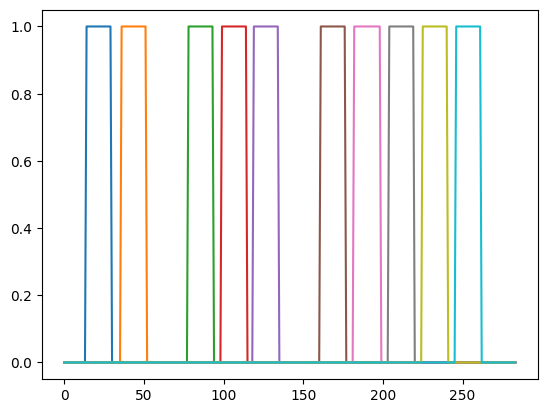

In [38]:
plt.plot(binary_design)

In [ ]:
def 